In [1]:
# --- Setup: make local package importable from /src and load core functions ---
# Notebook runs from /notebooks, so we add ../src to sys.path.
# Keep imports minimal here; anything reusable should live in src/picml/.
import sys
from pathlib import Path

# we are in notebooks/, so repo root is one level up
ROOT = Path.cwd().parent
sys.path.insert(0, str(ROOT / "src"))

from picml.dataio import load_case_B
print("✅ Imported load_case_B")


✅ Imported load_case_B


In [2]:
import sys
print(sys.executable)
print(sys.version)

/u/60/pereire1/unix/miniconda3/envs/picml/bin/python
3.11.14 (main, Oct 21 2025, 18:31:21) [GCC 11.2.0]


In [3]:
import tensorflow as tf
print(tf.__version__)


2026-01-09 12:53:14.476951: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-09 12:53:14.477212: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-09 12:53:14.513588: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-09 12:53:15.419121: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

2.20.0


In [4]:
from picml.utils import fidelity_imag
from picml.theory import select_datay_ring_major_order
from picml.models import create_model_B_1
from sklearn.model_selection import train_test_split
from picml.training import train_case_B_model1
from picml.theory import load_frequencies, generate_case_B_model2_spectra
from picml.models import create_model_B_2
from picml.training import train_case_B_model2
from picml.utils import sort_by_peak_frequency

In [5]:
import numpy as np
import math as m
import scipy
from scipy import linalg
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow import keras

In [6]:
import numpy as np
import os

# --- Load Case B dataset (measured spectra X and targets y) ---
# X: measured spectra per ring (rows = chains*rings, cols = frequency bins)
# y: onsite loss per ring (same row order as X)

Xs, y = load_case_B(use_compensated=False)
y = y.reshape(-1, 1)

print("X:", Xs.shape)
print("y:", y.shape)



X: (2400, 40)
y: (2400, 1)


In [7]:
#Selecting the data from the available data such that they lie between resonant frequency + epsilon and resonant frequency -epsilon
epsilon = np.array([5.5,5.5,5.5,5.5,5.5,5.5,5.5,5.5])/1.
chosendatay, chosenX = select_datay_ring_major_order(y, Xs,np.zeros_like(epsilon), epsilon)

print("shape of chosendatay : ",chosendatay.shape)
print("shape of chosenX : ",chosenX.shape)

shape of chosendatay :  (1533,)
shape of chosenX :  (1533, 40)


In [8]:
# --- Train/test split by chain (not by individual rings) ---
X_train, X_test, y_train, y_test = train_test_split(chosenX, chosendatay, test_size=0.2)
print(X_train.shape)
print(X_test.shape)

(1226, 40)
(307, 40)


In [9]:
# --- Scale inputs (X,y) 
# IMPORTANT: fit scaler on train only; apply to test with transform().
scalerx = StandardScaler()
X_train_scaled = scalerx.fit_transform(X_train)
X_test_scaled = scalerx.transform(X_test)


from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler
from sklearn.pipeline import make_pipeline

target_scaler = make_pipeline(PowerTransformer(method='yeo-johnson', standardize=True), MinMaxScaler())
y_train0=y_train.reshape(-1,1)
target_scaler.fit(y_train0)
y_train_scaled=target_scaler.transform(y_train.reshape(-1,1))
y_test_scaled=target_scaler.transform(y_test.reshape(-1,1))


"Stage 1 : prediction of Hamiltonian parameters"

In [10]:
# --- Stage 1: predict onsite loss from measured spectra ---
# Model 1 learns y from X_train_scaled.
# Keep a short smoke-test first; increase epochs only after plumbing works.

model = create_model_B_1(input_shape=X_train_scaled.shape[1:])
model.summary()


2026-01-09 12:53:18.043550: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ x_input (InputLayer)            │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 40)             │         1,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │         1,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,761 (14.69 KB)

 Trainable params: 3,761 (14.69 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# --- Stage 1 evaluation ---
# Print a few predictions vs truth to catch obvious failures (constant output, NaNs, etc.).

model.compile(optimizer="adam", loss="mse")

history = model.fit(
    X_train_scaled,
    y_train,
    epochs=2,          # just a smoke test
    batch_size=16,
    validation_split=0.2,
    verbose=1
)

loss = model.evaluate(X_test_scaled, y_test, verbose=0)
print("Test loss:", float(loss))

Epoch 1/2
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.9048 - val_loss: 1.7561
Epoch 2/2
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9794 - val_loss: 0.8353
Test loss: 0.7984970211982727


In [12]:

model, history.history, test_loss = train_case_B_model1(X_train_scaled,
    y_train_scaled,
    X_test_scaled,
    y_test_scaled)

# Evaluate
loss = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)
print("Test loss:", float(loss))

# Predictions (optional)
y_pred_train = model.predict(X_train_scaled)
y_pred_test  = model.predict(X_test_scaled)

print("y_pred_train:", y_pred_train.shape, "y_train:", y_train.shape)
print("y_pred_test :", y_pred_test.shape,  "y_test :", y_test.shape)

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4545 - val_loss: 0.2212 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0893 - val_loss: 0.0222 - learning_rate: 0.0010
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0142 - val_loss: 0.0107 - learning_rate: 9.5062e-04
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0082 - val_loss: 0.0080 - learning_rate: 9.2686e-04
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0068 - val_loss: 0.0074 - learning_rate: 9.0369e-04
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0056 - val_loss: 0.0064 - learning_rate: 8.8110e-04
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0047 - val_loss: 0.0053 - learning_rate: 8.5907e-04
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0042 - val_loss: 0.0051 - learning_rate: 8.3759e-04
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0038 - val_loss: 0.0049 - learning_rate: 8.

In [13]:
print(np.max(y_pred_train))
print(np.max(y_train))

1.0355496
5.4897365910840765


In [14]:
print(X_test_scaled.shape)
print(y_test_scaled.shape)
print(type(X_test_scaled), type(y_test_scaled))
print(hasattr(X_test_scaled, 'shape'), hasattr(y_test_scaled, 'shape'))


(307, 40)
(307, 1)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
True True


In [15]:
# --- Stage 1 diagnostic metric (fidelity/correlation-like) ---
# Uses picml.utils.fidelity_imag; do not redefine it here.
# Watch out: if predictions collapse to constant, variance ~0 and fidelity can be NaN.
y_pred_train1 = np.squeeze(target_scaler.inverse_transform(y_pred_train.reshape(-1, 1)))  # Flattening to shape (40000,)
y_pred_test1 = np.squeeze(target_scaler.inverse_transform(y_pred_test.reshape(-1, 1)))  # Flattening to shape (40000,)
print(np.max(y_pred_test))
# Fidelity
F_imag_train = fidelity_imag(y_pred_train1, y_train)
F_imag = fidelity_imag(y_pred_test1, y_test)
    
print(f"Fidelity (Imag): Train ( {F_imag_train:.4f}), Test ({F_imag:.4f})")

# Diagnostics: Check for constant outputs
print(f"Variance of Predictions (Train): {np.var(y_pred_train, axis=0)}")
print(f"Variance of Predictions (Test): {np.var(y_pred_test, axis=0)}")


1.0134254
Fidelity (Imag): Train ( 0.9921), Test (0.9832)
Variance of Predictions (Train): [0.07169515]
Variance of Predictions (Test): [0.07233648]


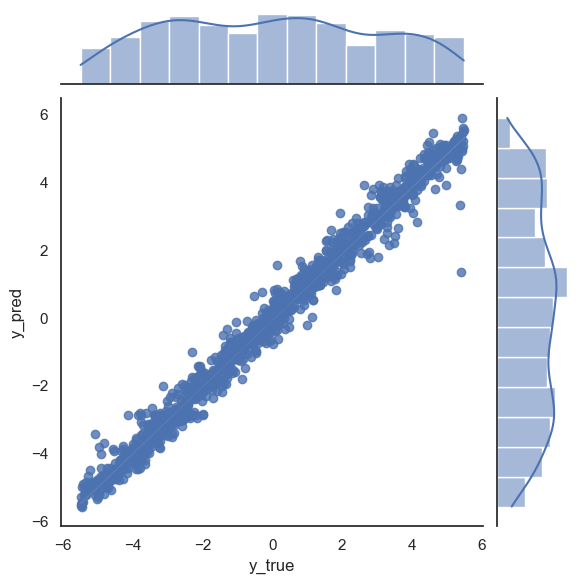

In [16]:
# plot predicted vs true Hamiltonian parameters
import pandas as pd
import seaborn as sns
y_true =y_train.flatten() #y_train_scaled.flatten()
y_pred = y_pred_train1.flatten()

#Convert validation predictions to pandas dataframe
df_pred_train = pd.DataFrame({'y_true':y_true, 'y_pred': y_pred})

# Create scatter plot with histograms for visualizing the density
sns.set(style="white", color_codes=True)
g = sns.jointplot(x='y_true', y='y_pred', data=df_pred_train, kind="reg")

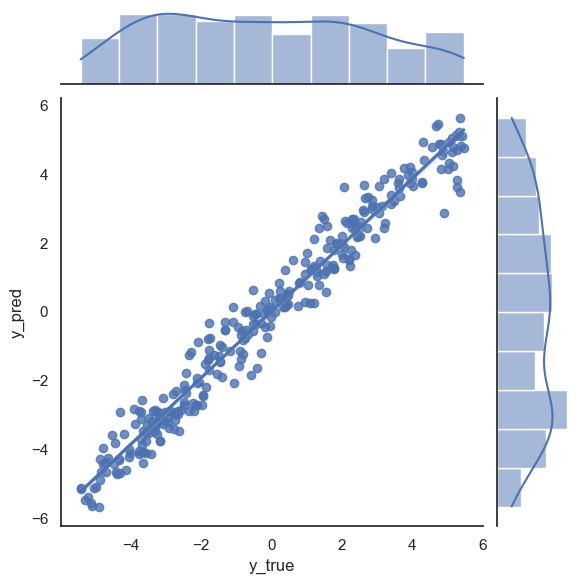

In [17]:
import pandas as pd
import seaborn as sns
y_truet = y_test.flatten()   #y_test_scaled.flatten()
y_predt = y_pred_test1.flatten()

#Convert validation predictions to pandas dataframe
df_pred_test = pd.DataFrame({'y_true':y_truet, 'y_pred': y_predt})

# Create scatter plot with histograms for visualizing the density
sns.set(style="white", color_codes=True)
g = sns.jointplot(x='y_true', y='y_pred', data=df_pred_test, kind="reg")

"Stage 2 : prediction of experimental data from the theory data of predicted parameters"

In [18]:
from pathlib import Path
import numpy as np

from picml.theory import load_frequencies, generate_case_B_model2_spectra
# (or from picml.theory import ... if you renamed)

DATA_DIR = Path.cwd().parent / "data"/"case_B"
freqs = load_frequencies(DATA_DIR / "frequencies.txt", scale_2pi=True)

frequencies_num = list(enumerate(freqs))
print("length of frequencies :", len(freqs))

y_combined_true = np.concatenate([y_true, y_truet], axis=0)[:1528].reshape(-1, 8)
y_combined_pred = np.concatenate([y_pred, y_predt], axis=0)[:1528].reshape(-1, 8)
new_chosenX_combined = np.concatenate([X_train, X_test], axis=0)[:1528]

print("y_combined_true shape :", y_combined_true.shape)  
print("y_combined_pred shape :", y_combined_pred.shape)
print("new_chosenX_combined shape :", new_chosenX_combined.shape)

length of frequencies : 40
y_combined_true shape : (191, 8)
y_combined_pred shape : (191, 8)
new_chosenX_combined shape : (1528, 40)


In [19]:
X_true, X_predicted = (
    generate_case_B_model2_spectra(
        y_combined_true,
        y_combined_pred,
        frequencies=freqs,
        gamma=0.1,
        coupling=0.82,
    )
)
print("X_true shape :", X_true.shape)  
print("X_predicted shape :", X_predicted.shape) 

X_true shape : (1528, 40)
X_predicted shape : (1528, 40)


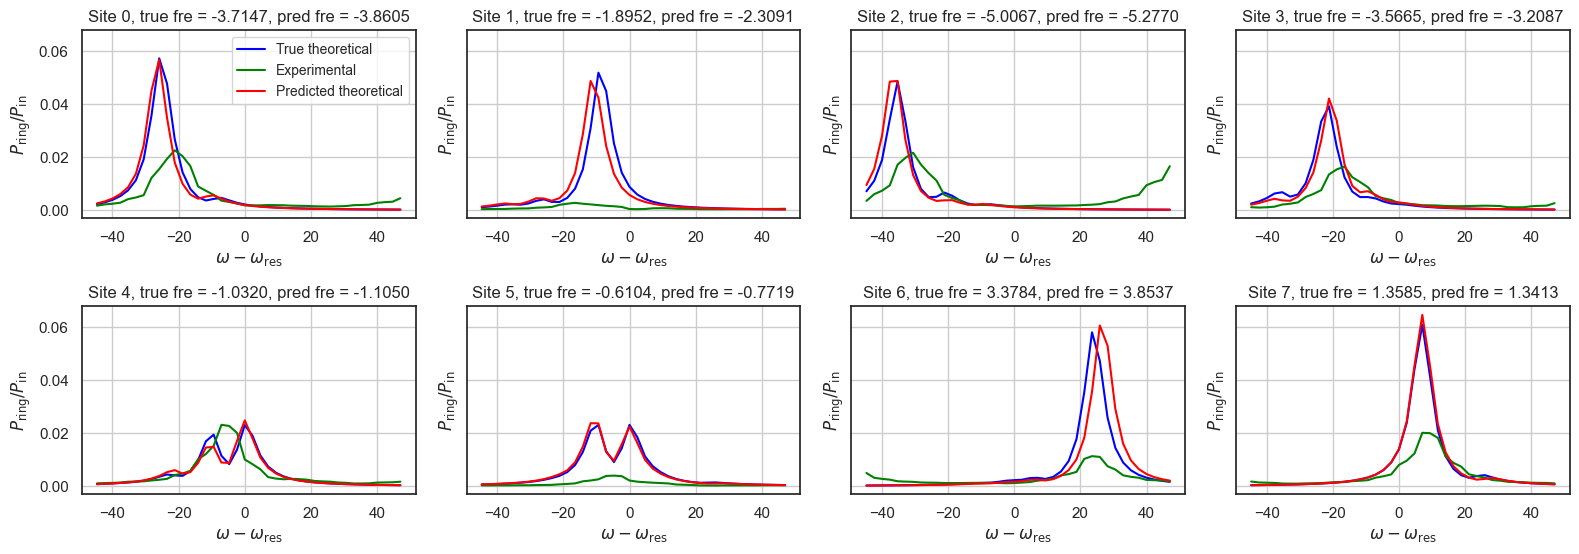

In [20]:
import numpy as np
import matplotlib.pyplot as plt

plotx = freqs


fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 6), sharex=True, sharey=True)

k = 5 #0 to 39
for i in range(8):
    ax = axes[i // 4, i % 4]  # Row-major order: 2 rows, 4 columns

    ax.plot(freqs, X_true[i+(8*k), :], label='True theoretical', color='blue')
    ax.plot(freqs, new_chosenX_combined[i+(8*k), :], label='Experimental', color='green')
    ax.plot(freqs, X_predicted[i+(8*k), :], label='Predicted theoretical', color='red')

    #ax.set_title(f"Site {i}, sample {k+1}")
    ax.set_title(f"Site {i}, true fre = {y_combined_true[k,i]:.4f}, pred fre = {y_combined_pred[k,i]:.4f}")
    ax.set_xlabel(r"$\omega-\omega_{\mathrm{res}}$")
    ax.set_ylabel(r"$P_{\mathrm{ring}}/P_{\mathrm{in}}$")
    ax.grid(True)
    
    if i // 4 == 0:  # First row: force show x-tick labels
        ax.tick_params(labelbottom=True)

    if i == 0:
        ax.legend(fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle
plt.show()

In [21]:
new_X = X_predicted
new_Y = new_chosenX_combined
print(new_X.shape,new_Y.shape)
new_X_train, new_X_test, new_y_train, new_y_test,y_comb_pred_train,y_comb_pred_test = train_test_split(new_X, new_Y,y_combined_pred.flatten(), test_size=0.2)
print(new_X_train.shape)
print(new_X_test.shape)
print(y_comb_pred_test.shape)

(1528, 40) (1528, 40)
(1222, 40)
(306, 40)
(306,)


In [22]:
# --- scale Stage 2 inputs (new_X, new_y) ---

scalernx = StandardScaler()
new_X_train_scaled = scalernx.fit_transform(new_X_train)
new_X_test_scaled = scalernx.transform(new_X_test)


scalerny = StandardScaler()
new_y_train_scaled = scalerny.fit_transform(new_y_train)
new_y_test_scaled = scalerny.transform(new_y_test)


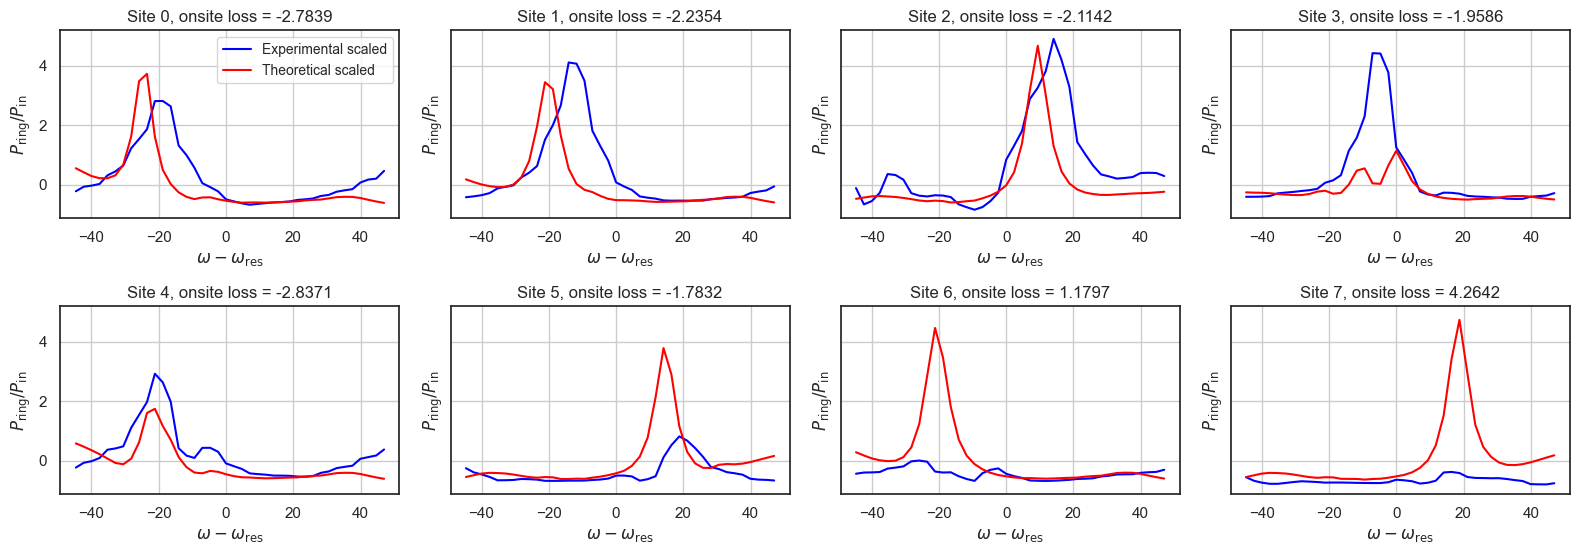

In [23]:
import numpy as np
import matplotlib.pyplot as plt

plotx = freqs


fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 6), sharex=True, sharey=True)

k = 7
for i in range(8):
    ax = axes[i // 4, i % 4]  # Row-major order: 2 rows, 4 columns

    ax.plot(freqs, new_y_train_scaled[i+(8*k), :], label='Experimental scaled', color='blue')
    ax.plot(freqs, new_X_train_scaled[i+(8*k), :], label='Theoretical scaled', color='red')

    #ax.set_title(f"Site {i}, sample {k+1}")
    ax.set_title(f"Site {i}, onsite loss = {y_combined_pred[k,i]:.4f}")
    ax.set_xlabel(r"$\omega-\omega_{\mathrm{res}}$")
    ax.set_ylabel(r"$P_{\mathrm{ring}}/P_{\mathrm{in}}$")
    #ax.set_ylim(y_min, y_max)
    ax.grid(True)
    
    if i // 4 == 0:  # First row: force show x-tick labels
        ax.tick_params(labelbottom=True)

    if i == 0:
        ax.legend(fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle
#plt.savefig("spectra_sample_24.png", dpi=300, bbox_inches='tight')
plt.show()


In [24]:
# --- Stage 2: learn mapping from theory spectra -> corrected/normalized experimental spectra ---
# Model lives in picml.models (keep architecture out of notebook).
# Add channel dim for Conv1D: (n_samples, n_freqs, 1).

import numpy as np

new_X_train_scaled_cnn = new_X_train_scaled[..., np.newaxis]
new_X_test_scaled_cnn = new_X_test_scaled[..., np.newaxis]

model_sc, history_sc, test_loss = train_case_B_model2(
    new_X_train_scaled_cnn,
    new_y_train_scaled,
    new_X_test_scaled_cnn,
    new_y_test_scaled)

loss = model_sc.evaluate(new_X_test_scaled_cnn, new_y_test_scaled, verbose=0)
print("Stage-2 test loss:", float(loss))

new_y_pred_train = model_sc.predict(new_X_train_scaled_cnn)
new_y_pred_test  = model_sc.predict(new_X_test_scaled_cnn)

print("pred train:", new_y_pred_train.shape, "true train:", new_y_train.shape)
print("pred test :", new_y_pred_test.shape,  "true test :", new_y_test.shape)


Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.9650 - val_loss: 1.0351
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8655 - val_loss: 1.0046
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7902 - val_loss: 0.9897
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7551 - val_loss: 0.9560
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7370 - val_loss: 0.9147
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6984 - val_loss: 0.8687
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6777 - val_loss: 0.7882
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6652 - val_loss: 0.7344
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6589 - val_loss: 0.7547
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6539 - val_loss: 0.7009
Epoch 11/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6284 - val_loss: 0.6874
Epoch 12/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6

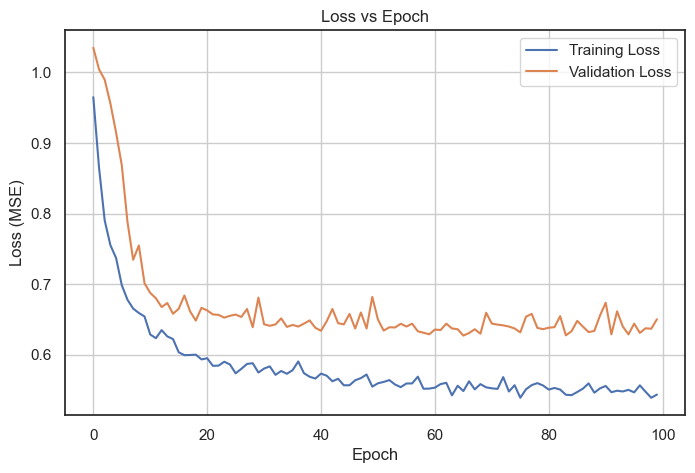

In [26]:
import matplotlib.pyplot as plt

# Extract training and validation loss from history
train_loss = history_sc['loss']
val_loss = history_sc['val_loss']

# Plot
plt.figure(figsize=(8,5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()


In [27]:
pred_y_train = scalerny.inverse_transform(new_y_pred_train)
pred_y_test = scalerny.inverse_transform(new_y_pred_test)


true_y_train = new_y_train
true_y_test = new_y_test


In [28]:
print(pred_y_test.shape)
print(y_comb_pred_test.flatten().shape)

(306, 40)
(306,)


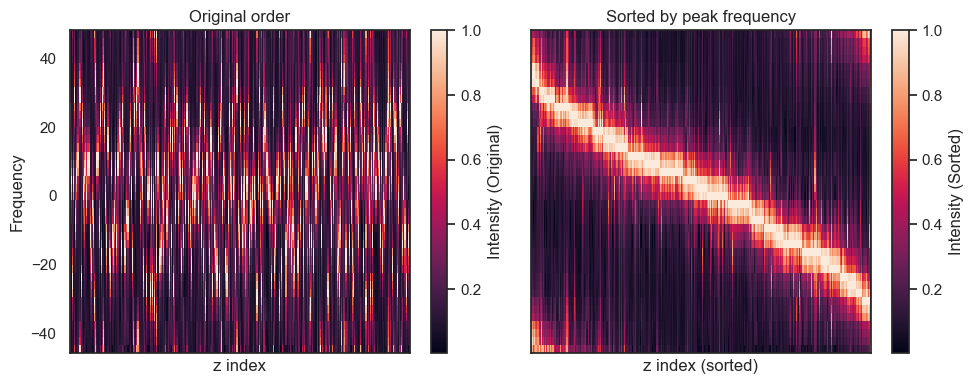

In [29]:
# --- Stage 2 evaluation and qualitative check --- for true power spectra
# Plot a few spectra overlays to see whether model 2 corrects systematic mismatch.
# Use shared color limits when comparing heatmaps across panels.

import numpy as np
import matplotlib.pyplot as plt


# --- Example data ---
z = np.array(y_comb_pred_test.flatten())
frequencies1 = np.array(freqs)
S = true_y_test / np.max(true_y_test, axis=1, keepdims=True)


# --- Sorting by where each row peaks ---
z_new, S_new, order = sort_by_peak_frequency(z, S)

# numeric z positions for plotting
z_numeric     = np.arange(len(z))
z_numeric_new = np.arange(len(z_new))

# --- Plot side-by-side: Original vs Sorted (z on x, f on y) ---
fig, axs = plt.subplots(1, 2, figsize=(10,4), sharey=True)

# Left: Original
pc1 = axs[0].pcolormesh(z_numeric, frequencies1, S.T, shading='auto')
axs[0].set_title("Original order")
axs[0].set_xlabel("z index")
axs[0].set_ylabel("Frequency")
axs[0].set_xticks([])
fig.colorbar(pc1, ax=axs[0], label="Intensity (Original)")

# Right: Sorted
pc2 = axs[1].pcolormesh(z_numeric_new, frequencies1, S_new.T, shading='auto')
axs[1].set_title("Sorted by peak frequency")
axs[1].set_xlabel("z index (sorted)")
axs[1].set_xticks([])
fig.colorbar(pc2, ax=axs[1], label="Intensity (Sorted)")

plt.tight_layout()
plt.show()

In [30]:
#Sk = np.array(pred_y_test)
Sk = pred_y_test/ np.max(pred_y_test, axis=1, keepdims=True)

Sk_new = Sk[order, :]

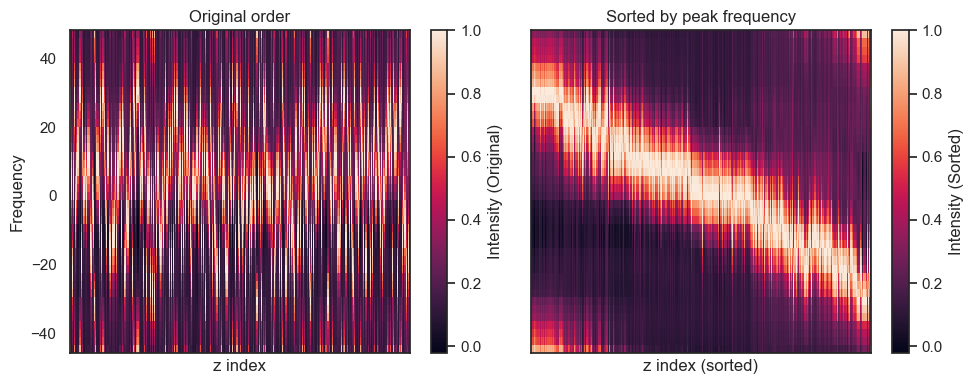

In [31]:
# --- Plot side-by-side: Original vs Sorted (z on x, f on y) --- for predicted output power spectra
fig, axs = plt.subplots(1, 2, figsize=(10,4), sharey=True)

# Left: Original
pc1 = axs[0].pcolormesh(z_numeric, freqs, Sk.T, shading='auto')
axs[0].set_title("Original order")
axs[0].set_xlabel("z index")
axs[0].set_ylabel("Frequency")
axs[0].set_xticks([])
fig.colorbar(pc1, ax=axs[0], label="Intensity (Original)")

# Right: Sorted
pc2 = axs[1].pcolormesh(z_numeric_new, freqs, Sk_new.T, shading='auto')
axs[1].set_title("Sorted by peak frequency")
axs[1].set_xlabel("z index (sorted)")
axs[1].set_xticks([])
fig.colorbar(pc2, ax=axs[1], label="Intensity (Sorted)")

plt.tight_layout()
plt.show()

In [44]:
#Save final output file
import numpy as np

# Suppose we already have:
# z_sorted : shape (N,) = (320,)
# frequencies : shape (F,) = (40,)
# S_sorted : shape (N, F)
# Sk_sorted : shape (N, F)

# --- Flatten to long table (z, freq, S, Sk) ---
N, F = S_new.shape

# Repeat z along each frequency
z_col0 = np.repeat(z_new + 0.5, F) 
z_col = np.repeat(z_numeric_new + 0.5, F)              # (N*F,)
# Tile frequencies for each z
f_col = np.tile(frequencies, N)             # (N*F,)

# Flatten spectra values
S_col  = S_new.flatten(order="C")        # (N*F,)
Sk_col = Sk_new.flatten(order="C")       # (N*F,)

# Stack into one 2D array
data = np.column_stack([z_col0,z_col, f_col, S_col, Sk_col])

# --- Save to file ---
header = "z_sorted\tz_sorted_numeric\tfrequency\tS_sorted\tSk_sorted"
np.savetxt(
    "predicted_result/spectra_sorted_case_B.dat",
    data,
    fmt="%.10g",
    delimiter="\t",
    header=header,
    comments=""
)

print("✅ Saved spectra_sorted_case_B.dat with shape", data.shape)

✅ Saved spectra_sorted.dat with shape (12240, 5)


"The End"
